## **MLP para classificação multiclasse de imagens**
**Dataset MNIST (Modified National Institute of Standards and Technology)**
- É considerado o dataset “hello world” de *computer vision*.
- Dataset de imagens de dígitos escritos manualmente
- Inputs: imagens de 28x28 pixeis
- Output: classe a representar o dígito (10 classes, dígitos 0-9)
- 70k imagens das quais 60k são para treino e 10k para teste
- 2 atributos: o id da imagem e o respetivo label   

Vamos utilizar uma rede neuronal para classificação do dígito em cada imagem de 28x28.

## Imports

In [5]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
    
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [40]:
PATH = './'
PATH_TRAIN = 'mnist_train.csv'
PATH_TEST = 'mnist_test.csv'

device = torch.device("cpu")

EPOCHS = 200
BATCH_SIZE = 90
LEARNING_RATE = 0.05

## 1. Preparar os Dados

In [41]:
class CSVDataset(Dataset):
    def __init__(self, path_train, path_test):
        
        df_train = pd.read_csv(PATH_TRAIN, header=None)
        df_test = pd.read_csv(PATH_TEST, header=None)

        
        self.x_train = df_train.values[:, 1:]
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        self.y_test = df_test.values[:, 0]
        
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')
        
    def __len_train__(self):
        return len(self.x_train)

    def __len_test__(self):
        return len(self.x_test)
    
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]

    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    def get_splits_flat(self):
        x_train  = torch.from_numpy(np.array(self.x_train))
        y_train  = torch.from_numpy(np.array(self.y_train))
        x_test  = torch.from_numpy(np.array(self.x_test))
        y_test  = torch.from_numpy(np.array(self.y_test))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        test = torch.utils.data.TensorDataset(x_test,y_test)
        return train, test 
    
def prepare_data_flat(path_train, path_test):
    dataset = CSVDataset(path_train, path_test)
    train, test = dataset.get_splits_flat()

    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [42]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path, header=None)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(y)

visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:60000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([90, 784]), output: torch.Size([90])
Shape tensor batch casos test, input: torch.Size([90, 784]), output: torch.Size([90])
tensor([5, 3, 0, 2, 7, 6, 8, 0, 2, 8, 1, 7, 2, 3, 0, 2, 5, 2, 8, 8, 1, 8, 1, 1,
        4, 0, 5, 1, 9, 1, 4, 4, 0, 4, 2, 1, 0, 1, 1, 6, 9, 2, 7, 7, 7, 4, 8, 2,
        4, 4, 9, 7, 8, 5, 6, 7, 6, 0, 4, 0, 3, 0, 0, 7, 0, 6, 8, 1, 8, 3, 1, 7,
        4, 2, 9, 1, 6, 8, 6, 4, 3, 4, 7, 1, 1, 1, 2, 2, 9, 1])


torch.Size([90, 784])
torch.Size([90, 1, 28, 28])


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

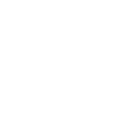

In [43]:
def visualize_mnist_images_flat(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(b=None)
        plt.imshow(inputs[i][0], cmap='gray')
    plt.show()

visualize_mnist_images_flat(train_dl)

## 1.2 Verificar balanceamento do dataset

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(dl):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x, y)
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.show() 

print("-----casos_treino------")   
visualize_holdout_balance(train_dl_all)
print("-----casos_teste------") 
visualize_holdout_balance(test_dl_all)

## 2. Definir o Modelo

In [44]:
from torchinfo import summary

class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 20)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(20, 20)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(20, 10)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax()
        
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        return X
    
model = MLP(784)
print(summary(model, input_size=(BATCH_SIZE, 784), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [90, 10]                  --
├─Linear: 1-1                            [90, 20]                  15,700
├─ReLU: 1-2                              [90, 20]                  --
├─Linear: 1-3                            [90, 20]                  420
├─ReLU: 1-4                              [90, 20]                  --
├─Linear: 1-5                            [90, 10]                  210
├─Softmax: 1-6                           [90, 10]                  --
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
Total mult-adds (M): 1.47
Input size (MB): 0.28
Forward/backward pass size (MB): 0.04
Params size (MB): 0.07
Estimated Total Size (MB): 0.38


/tmp/ipykernel_7705/1074764931.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act3(X)


MLP(
  (hidden1): Linear(in_features=784, out_features=20, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=20, out_features=20, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=20, out_features=10, bias=True)
  (act3): Softmax(dim=None)
)

## 3. Treinar o Modelo

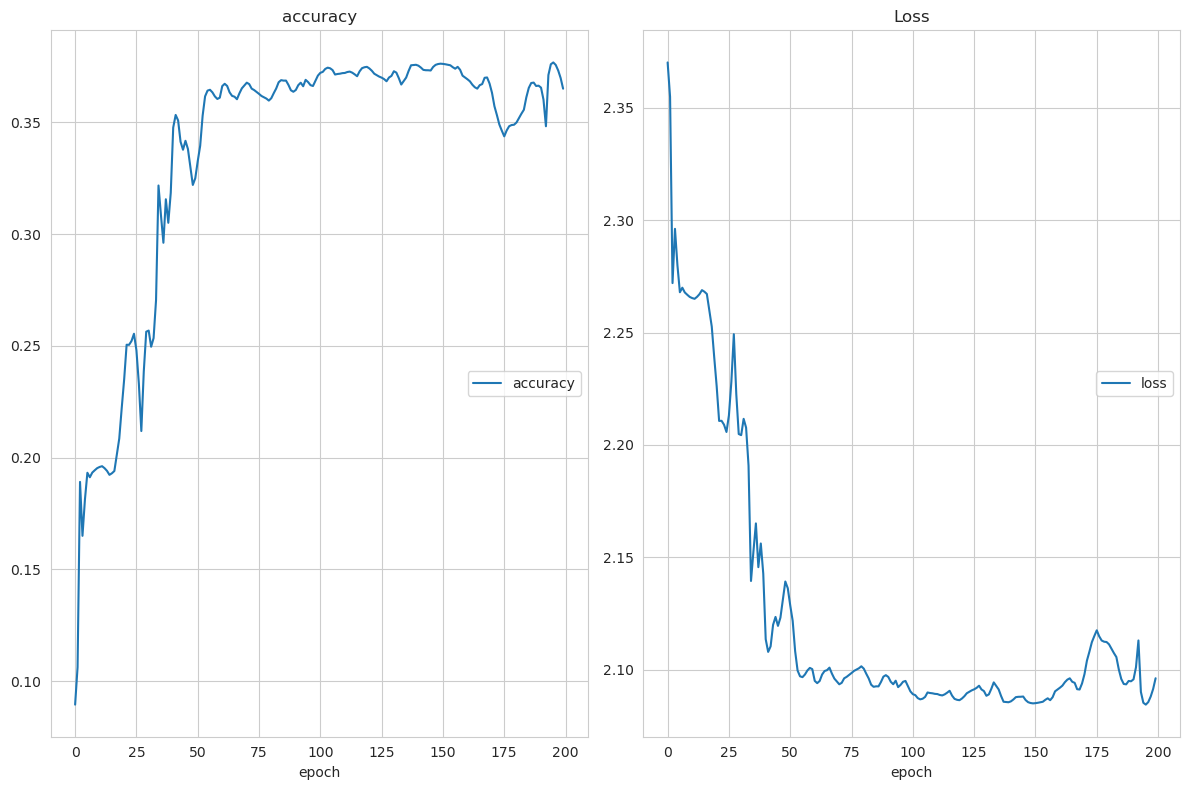

accuracy
	accuracy         	 (min:    0.089, max:    0.377, cur:    0.365)
Loss
	loss             	 (min:    2.084, max:    2.370, cur:    2.096)


In [45]:
from livelossplot import PlotLosses



def train_model(train_dl, model):
    liveloss = PlotLosses()
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss  = 0 
        epoch_acc  = 0 
        for i, (inputs, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        logs['loss'] = epoch_loss
        logs['accuracy'] = epoch_acc/len(train_dl)
        liveloss.update(logs)
        liveloss.send()

train_model(train_dl_all, model)

## 4. Avaliar o Modelo

/tmp/ipykernel_7705/1074764931.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act3(X)
/home/franciscoizquierdo/anaconda3/envs/AprendizagemProfunda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franciscoizquierdo/anaconda3/envs/AprendizagemProfunda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franciscoizquierdo/anaconda3/envs/AprendizagemProfunda/lib/python3.9/site-packages/sklearn/met

Accuracy: 0.361

acertou:3606 falhou:6394
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.25      0.95      0.39      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.28      0.96      0.43       958
           7       0.71      0.93      0.80      1028
           8       0.00      0.00      0.00       974
           9       0.55      0.75      0.63      1009

    accuracy                           0.36     10000
   macro avg       0.18      0.36      0.23     10000
weighted avg       0.18      0.36      0.23     10000

[[  0   0 393   0   0   0 475  67   0  45]
 [  0   0 899   0   0   0 212  12   0  12]
 [  0   0 978   0   0   0  31  20   0   3]
 [  0   0 761   0   0   0 105  77   0  67]
 [  0   0  28   0   0   0 6

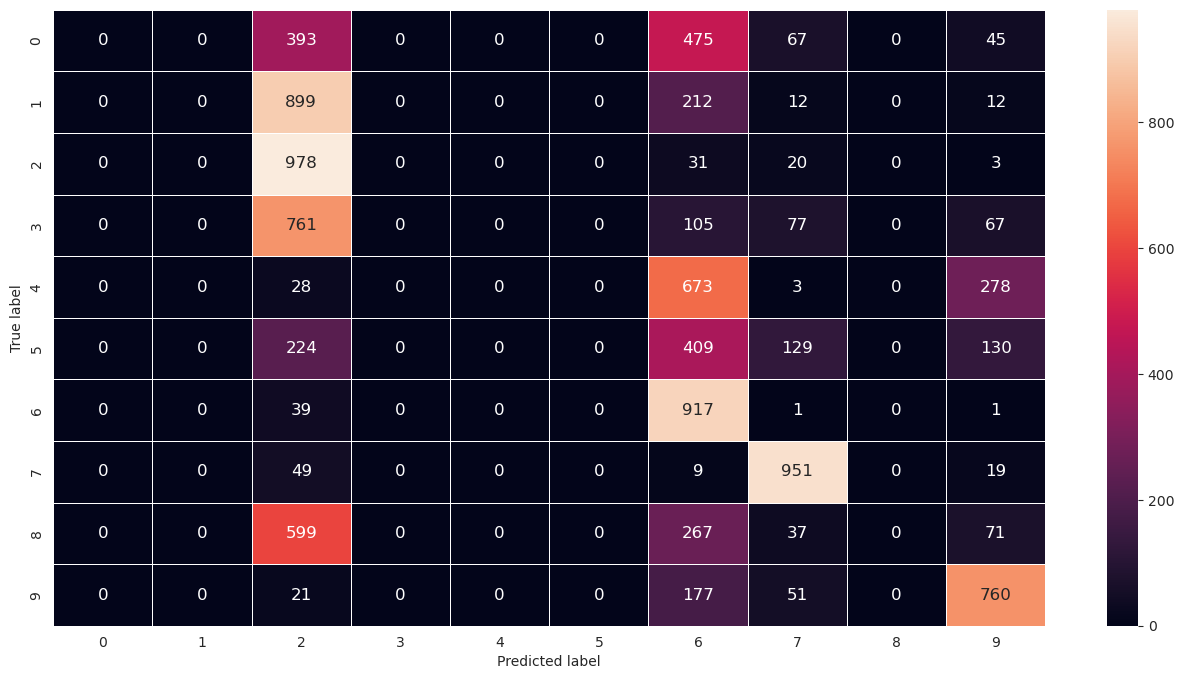

In [58]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return predictions, actual_values

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
predictions, actual_values = evaluate_model(test_dl, model)


acertou=0
falhou = 0
for r,p in zip(actual_values, predictions):
    if r==p: acertou+=1  
    else: falhou+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')

print(classification_report(actual_values, predictions))

cm = confusion_matrix(actual_values, predictions)
print (cm)
display_confusion_matrix(cm, [i for i in range(10)])

## 5. Usar o Modelo

torch.Size([90, 784])
torch.float32
predict: 2


/tmp/ipykernel_7705/1074764931.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act3(X)


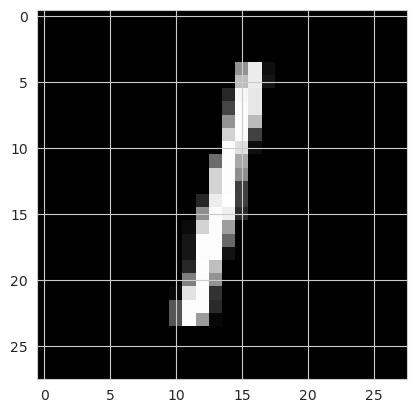

In [57]:
def make_prediction(model, img_list, idx):
    print(img_list.shape)
    print(img_list.dtype)
    img_list = img_list.to(device)
    prediction = model(img_list).detach().numpy()[idx].argmax()
    print("predict:",prediction)
    img = img_list[idx].reshape(1,28, 28)
    plt.imshow(img[0], cmap=plt.get_cmap('gray'))
    plt.show()
    
_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10)